## 1. Data Cleaning

**Data Cleaning**

- **Missing Values**: Checked using `isnull().sum()`, and one row were found.
- **Outliers**: Handled with visualizations like boxplots. Since fraud data can be naturally extreme, only modeling addressed these.
- **Multicollinearity**: Checked using VIF; features with high multicollinearity were addressed.
    

## 2. Fraud Detection Model

**Model Description**

- Used **Random Forest**, **Logistic Regression**, and **XGBoost**.
- **SMOTE** applied to balance training data only.
- **GridSearchCV** used for hyperparameter tuning.
    

## 3. Feature Selection

**Feature Selection**

- Based on EDA insights and correlation heatmaps.
- Importance from Random Forest guided final selection.
    

## 4. Model Performance

**Performance Metrics**

- Evaluated with **Precision**, **Recall**, **F1-Score**, **ROC-AUC**.
- Confusion matrix visualized.
    

## 5. Key Fraud Predictors

**Key Predictors**

- `amount`, `oldbalanceOrg`, `newbalanceOrig`, `type`, `isFlaggedFraud`.
    

## 6. Factor Validation

**Do These Make Sense?**

Yes, because:
- High amounts or sudden balance drops are suspicious.
- Certain types (`TRANSFER`, `CASH_OUT`) are frequently used in fraud.
    

## 7. Fraud Prevention Strategies

**Prevention Methods**

- Real-time ML-based transaction monitoring.
- Two-factor authentication.
- Hybrid flagging with rules + ML.
    

## 8. Measuring Effectiveness

**Post-Implementation Tracking**

- Monitor fraud rates over time.
- Compare detection rates before/after.
- Use A/B testing and feedback from investigation teams.
    

In [ ]:
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Ignore warnings for better readability
import warnings
warnings.filterwarnings('ignore')

# Set a visual style
sns.set_style("whitegrid")

In [ ]:
df = pd.read_csv("/content/Fraud.csv")

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [ ]:
df.shape

(6362620, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [ ]:
# Check for null values
# so there is only one row which has missing value index = 233391
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [ ]:
df[df['nameDest'].isnull()]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [ ]:
df[df['oldbalanceDest'].isnull()]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [ ]:
df[df['newbalanceDest'].isnull()]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [ ]:
df = df.drop(index=233391)

Text(0.5, 1.0, 'Transaction Amount Distribution')

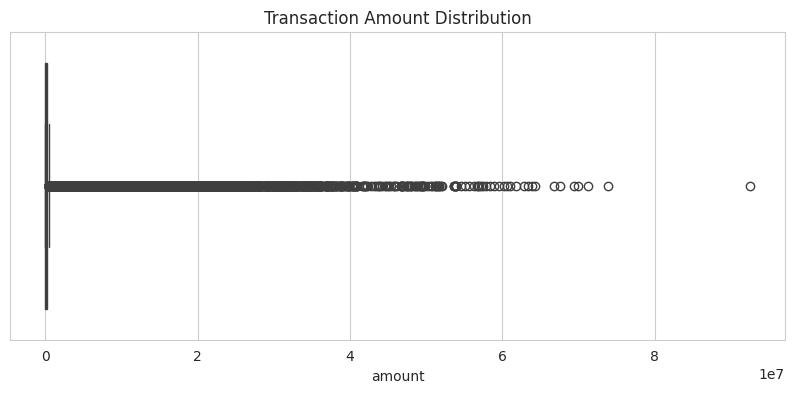

In [ ]:
# outlier treatment
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot for amount
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['amount'])
plt.title("Transaction Amount Distribution")


In [ ]:
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1

# Find outliers
outliers = df[(df['amount'] < (Q1 - 1.5 * IQR)) | (df['amount'] > (Q3 + 1.5 * IQR))]
print("Number of outliers:", outliers.shape[0])

Number of outliers: 338077


Text(0.5, 1.0, 'Correlation Heatmap')

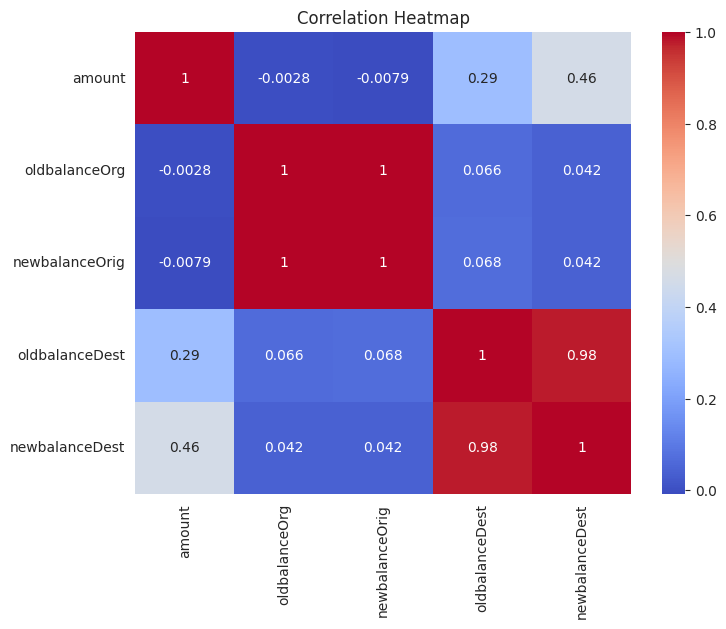

In [ ]:
numeric_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
corr_matrix = df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select only numeric features for VIF calculation
numeric_features = df.select_dtypes(include=np.number).columns
# Create a DataFrame for VIF values
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_features

# Calculate VIF for each numeric feature
vif_data["VIF"] = [variance_inflation_factor(df[numeric_features].values, i) for i in range(len(numeric_features))]

# Display VIF results
vif_data

,feature,VIF
0,step,1.191094
1,amount,4.078952
2,oldbalanceOrg,544.053106
3,newbalanceOrig,546.346011
4,oldbalanceDest,72.895527
5,newbalanceDest,84.584625
6,isFraud,1.188386
7,isFlaggedFraud,1.002546


In [ ]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 6362619 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 582.5+ MB


,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


<Axes: ylabel='count'>

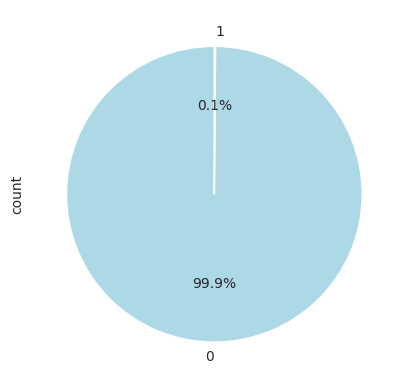

In [ ]:
df['isFraud'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors = ['#add8e6', '#90ee90'])

(0.0, 5000000.0)

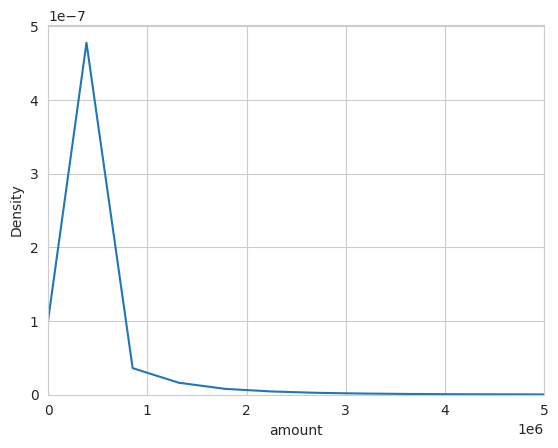

In [ ]:
sns.kdeplot(df,x='amount')
plt.xlim(0,5000000)

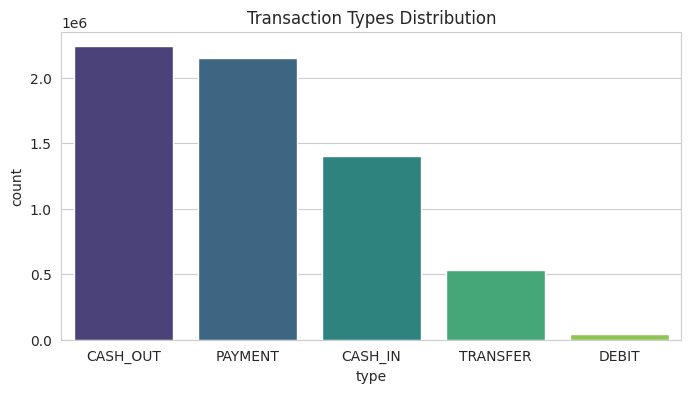

In [ ]:
# Count transaction types
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x="type", palette="viridis", order=df["type"].value_counts().index)
plt.title("Transaction Types Distribution")
plt.show()

In [ ]:
df = df.drop(['nameOrig', 'nameDest'], axis=1)

In [ ]:
# Convert 'type' to numerical values using Label Encoding
encoder = LabelEncoder()
df["type"] = encoder.fit_transform(df["type"])

In [ ]:
# Downsample majority class (non-fraud transactions) to match the minority class
fraud = df[df["isFraud"] == 1]
non_fraud = df[df["isFraud"] == 0].sample(n=len(fraud), random_state=42)

# Combine fraud and non-fraud samples
balanced_df = pd.concat([fraud, non_fraud])

# Shuffle dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
X = balanced_df.drop("isFraud", axis=1)
y = balanced_df["isFraud"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9914790018259282
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1622
           1       0.99      1.00      0.99      1664

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286



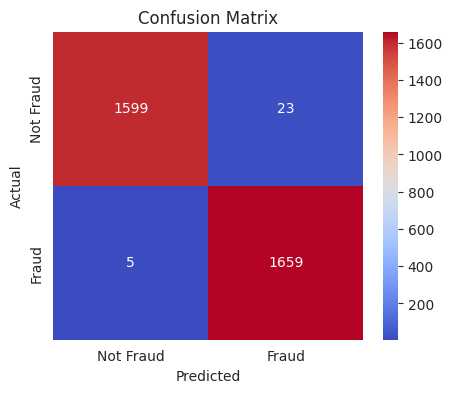

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
y_probs = model.predict_proba(X_test)[:, 1]  # Probabilities of being fraud
threshold = 0.3
y_pred_new = (y_probs > threshold).astype(int)
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1622
           1       0.98      1.00      0.99      1664

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286



In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1622
           1       0.99      1.00      0.99      1664

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286



In [ ]:
train_acc = xgb_model.score(X_train, y_train)
test_acc = xgb_model.score(X_test, y_test)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Training Accuracy: 0.9998
Test Accuracy: 0.9936


In [ ]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1622
           1       0.99      1.00      0.99      1664

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286



In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')

print(f"Cross-validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")

Cross-validation Accuracy Scores: [0.99178332 0.99147641 0.99512938 0.99269406 0.99360731]
Mean Accuracy: 0.9929


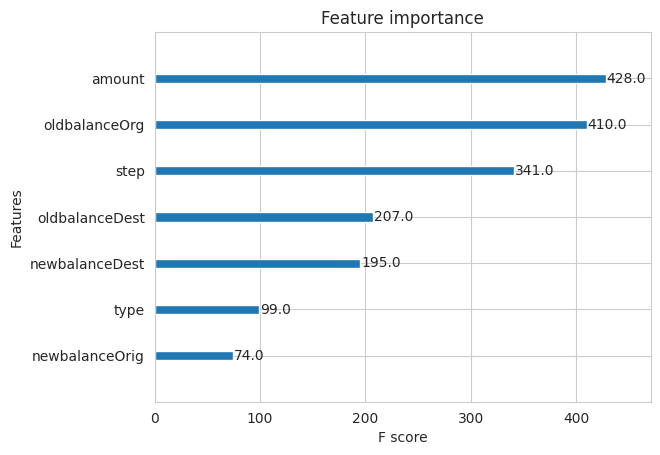

In [ ]:
xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()
model.add(Dense(13,activation='relu'))
model.add(Dense(7,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
early_stop=EarlyStopping(monitor='val_loss',mode='min',patience=4)

In [ ]:
history=model.fit(
    x=X_train,
    y=y_train,
    epochs=25,
    validation_data=(X_test,y_test),
    batch_size=256,
    callbacks=[early_stop]
)

Epoch 1/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4202 - loss: 186440.5469 - val_accuracy: 0.7553 - val_loss: 37104.5352
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8147 - loss: 35889.7031 - val_accuracy: 0.8758 - val_loss: 10846.4746
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8918 - loss: 5791.7095 - val_accuracy: 0.8971 - val_loss: 1542.7745
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8958 - loss: 1135.7665 - val_accuracy: 0.9145 - val_loss: 513.8411
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9054 - loss: 719.8406 - val_accuracy: 0.8889 - val_loss: 681.3361
Epoch 6/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9067 - loss: 551.3542 - val_accuracy: 0.9139 - val_loss: 460.5432
Epoch 7/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9030 - loss: 502.3989 - val_accuracy: 0.9108 - val_loss: 478.3047
Epoch 8/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9128 - loss: 4